# Interpretation of Best Models
Our baseline is a Logistic Regression classifier with a single feature (evictions the previous year) and the default parameters.   
Our best classifier is a Gradient Boosting with the following parameters: 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5.  
Our best regressor is a Decision Tree with the following parameters: 'max_depth': 50, 'max_features': None, 'min_samples_split': 10. 

This notebook produces additional deliverables upon selecting these models. This includes the following: 

For the baseline classifier: 
- A "stump" one-level decision tree ('stump.png')``
- The list of the top 14% of selected blocks ('baseline_selected_blocks.csv')
- The precision-recall curves ('baseline_pr_curve.png') 

For the best classifier: 
- The list of the top 14% selected blocks ('clf_selected_blocks.csv') 
- The list of feature importance ('clf_feature_importance.csv')
- The precision-recall curves ('clf_pr_curve.png')

For the best regressor: 
- The list of the top 14% selected blocks ('reg_selected_blocks.csv')
- The list of feature importance ('reg_feature_importance.csv')

And to compare the best classifier and best regressor: 
- The list of the top 14% blocks based on actual evictions, and the predictions yielded from the best classifier and best regressor for these blocks ('clf_reg_comparison.csv')

## Environment Setup

In [1]:
import pandas as pd
from os import path
from IPython.display import Image
import pipeline
from pipeline import analyze_best_model
from pipeline import clean 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## Pipeline Setup

In [2]:
df = pd.read_csv('data/final_merged_df.csv')

splits = pipeline.split_all_years(df, colname='year_evictions')
cleaned_splits = [pipeline.clean_split(split) for split in splits]
labeled_splits = [pipeline.label(split, lower_bound=15, drop_column=True)
                  for split in cleaned_splits]

test_year = 2016
splits_dict = {2011:0, 2012:1, 2013:2, 2014:3, 2015: 4, 2016: 5}
train_df, test_df = labeled_splits[splits_dict[test_year]] 

## Baseline Classifier
Logistic Regression classifier with a single feature (evictions the previous year) and the default parameters.   

In [3]:
params = {}
baseline_model, baseline_scores = pipeline.run_one_clf(
    train_df, test_df, 'LB', params, col_blacklist=['GEOID', 'year_evictions'])

#### "Stump" Decision Tree 

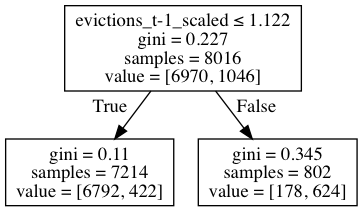

In [4]:
params = {'max_depth': 1}
dtree, dtree_scores = pipeline.run_one_clf(
    train_df, test_df, 'DT', params, col_blacklist=['GEOID', 'year_evictions'])
analyze_best_model.plot_tree(dtree, test_df, 'stump.png', test_year )
Image(filename=path.join('results', str(test_year), 'stump.png')) 

#### Selected Blocks

In [5]:
selected_blocks = analyze_best_model.select_k_blocks(baseline_scores, .14 , ['score'], ['GEOID'])
selected_blocks.to_csv(path.join('results', str(test_year), 'baseline_selected_blocks.csv'), index=False)
selected_blocks.head(10)

,GEOID
6215,421010273003
6978,421010301002
8315,421010346001
5389,421010243002
6103,421010268001
8511,421010353021
5711,421010257001
8938,421010373003
8385,421010348021
8658,421010361001


#### Precision-Recall Curves

<Figure size 432x288 with 0 Axes>

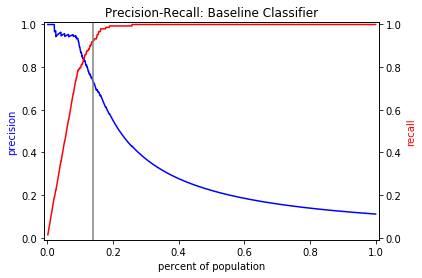

In [6]:
pipeline.plot_precision_recall_n(
    baseline_scores, .14, 'Precision-Recall: Baseline Classifier', 'baseline_pr_curve.png', test_year)

## Best Classifier
Gradient Boosting with the following parameters: 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5.  

In [7]:
params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
best_clf, clf_scores = pipeline.run_one_clf(
    train_df, test_df, 'GB', params, col_blacklist=['GEOID', 'year_evictions'])

#### Selected Blocks

In [8]:
selected_blocks = analyze_best_model.select_k_blocks(clf_scores, .14 , ['score'], ['GEOID'])
selected_blocks.to_csv(path.join('results', str(test_year), 'clf_selected_blocks.csv'), index=False)
selected_blocks.head(10)

,GEOID
8658,421010361001
6215,421010273003
4892,421010206001
3002,421010122012
8679,421010362011
6446,421010279021
8385,421010348021
4304,421010179004
5389,421010243002
6103,421010268001


#### Precision-Recall Curves

<Figure size 432x288 with 0 Axes>

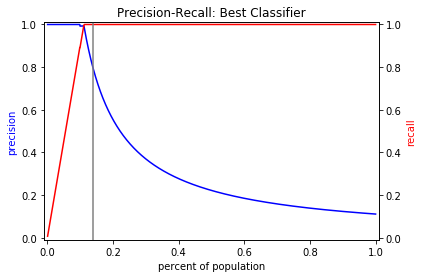

In [9]:
pipeline.plot_precision_recall_n(
    clf_scores, .14, 'Precision-Recall: Best Classifier', 'clf_pr_curve.png', test_year)

#### Feature Importance

In [10]:
importance = analyze_best_model.feature_importance(best_clf, test_df.columns)
importance.to_csv(path.join('results', str(test_year), 'clf_feature_importance.csv'), index=False)
importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.49
3,evictions_change_1,0.17
68,evictions_t-2_scaled,0.17
4,evictions_change_2,0.11
69,evictions_t-5_scaled,0.01
5,evictions_change_5,0.01
75,renter_occupied_household_size_scaled,0.00
10,for_rent_units_percent,0.00
81,for_rent_units_scaled,0.00
82,num_af_am_alone_scaled,0.00


## Best Regressor
Decision Tree with the following parameters: 'max_depth': 50, 'max_features': None, 'min_samples_split': 10.

In [11]:
train_df, test_df = cleaned_splits[splits_dict[test_year]] 
params = {'max_depth': 50, 'max_features': None, 'min_samples_split': 10}
best_reg, reg_scores = pipeline.run_one_reg(
    train_df, test_df, 'DTR', params, col_blacklist=['GEOID', 'year_evictions'])

#### Selected Blocks

In [12]:
selected_blocks = analyze_best_model.select_k_blocks(reg_scores, .14 , ['pred_evictions'], ['GEOID'])
selected_blocks.to_csv(path.join('results', str(test_year), 'reg_selected_blocks_clf.csv'), index=False)
selected_blocks.head(10)

,GEOID
6215,421010273003
6978,421010301002
8315,421010346001
5389,421010243002
5711,421010257001
6103,421010268001
3002,421010122012
4892,421010206001
8658,421010361001
8511,421010353021


#### Feature Importance

In [13]:
importance = analyze_best_model.feature_importance(best_reg, test_df.columns)
importance.to_csv(path.join('results', str(test_year), 'reg_feature_importance.csv'), index=False)
importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.72
3,evictions_change_1,0.21
21,evictions_change_1_binary,0.04
68,evictions_t-2_scaled,0.02
5,evictions_change_5,0.00
23,evictions_change_5_binary,0.00
69,evictions_t-5_scaled,0.00
77,median_household_income_scaled,0.00
4,evictions_change_2,0.00
22,evictions_change_2_binary,0.00


## Comparing Best Classifier and Best Regressor

In [14]:
comparison = analyze_best_model.clf_reg_comparison(
    best_clf, clf_scores, best_reg, reg_scores, test_df, .14)
comparison.to_csv(path.join('results', str(test_year), 'clf_reg_comparison.csv'), index=False)
comparison.head(10).round(2)

,GEOID,actual_evictions,clf_pred_score,reg_pred_evictions
0,421010273003,128.0,1.0,75.50
1,421010301002,83.0,1.0,69.33
2,421010361001,78.0,1.0,51.67
5,421010346001,58.0,1.0,54.33
3,421010243002,58.0,1.0,53.38
4,421010268001,58.0,1.0,53.38
6,421010257001,51.0,1.0,53.38
7,421010206001,50.0,1.0,51.67
8,421010353021,49.0,1.0,44.43
9,421010348021,47.0,1.0,38.57


## Comparing Selected Blocks over Splits 

In [15]:
df_11 = pd.read_csv('results/2011/clf_selected_blocks.csv')
df_12 = pd.read_csv('results/2012/clf_selected_blocks.csv')
df_13 = pd.read_csv('results/2013/clf_selected_blocks.csv')
df_14 = pd.read_csv('results/2014/clf_selected_blocks.csv')
df_15 = pd.read_csv('results/2015/clf_selected_blocks.csv')
df_16 = pd.read_csv('results/2016/clf_selected_blocks.csv')

final_list = []
for n in [187, 100, 50]: 
    l = [n]
    for df in [df_11, df_12, df_13, df_14, df_15, df_16]:
        l.append(len(set(df['GEOID'][:n]).intersection(set(df_16['GEOID'])))/len(set(df_16['GEOID'][:n])))
    final_list.append(l)
comparison = pd.DataFrame(final_list, columns=['top_n', '2011', '2012', '2013', '2014', '2015', '2016']).round(2)
comparison.to_csv('results/selected_blocks_comparison.csv', index=False)
comparison

,top_n,2011,2012,2013,2014,2015,2016
0,187,0.66,0.67,0.65,0.66,0.67,1.0
1,100,0.86,0.85,0.81,0.80,0.81,1.0
2,50,0.88,0.90,0.86,0.94,0.92,1.0
